# Improved Seam Carving using Forward Energy 

Alexander Xu '19 & Mario Liu '19

In [1]:
from IPython.lib.display import YouTubeVideo

## Introduction

For more details on seam carving, please read

1) the [readme](https://github.com/axu2/improved-seam-carving)

2) the original seam carving demo video from 2007:

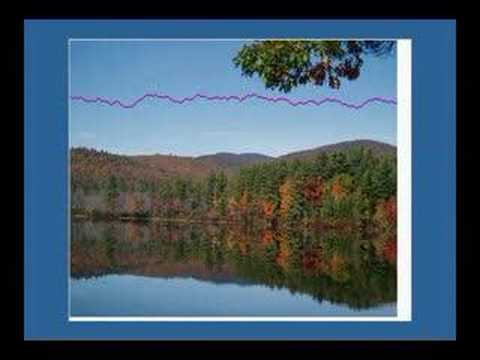

In [2]:
YouTubeVideo('6NcIJXTlugc')

and 3) the improved seam carving demo video from 2008:

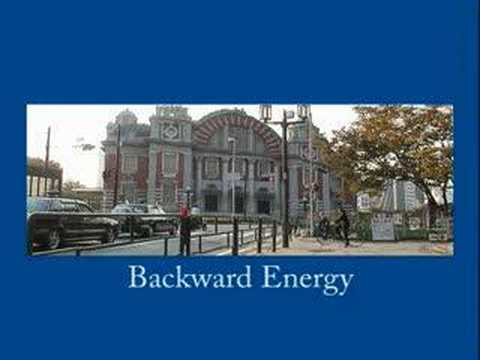

In [3]:
YouTubeVideo('AJtE8afwJEg')

I begin by importing everything I need and defining a few helper functions:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from skimage import io, transform, util
import numpy as np
from skimage import filters, color

from scipy import ndimage as ndi
from matplotlib import gridspec

In [5]:
def imread(filename):
    """For convenience since pixels are natively 8 bit ints"""
    return util.img_as_float(io.imread(filename))

In [6]:
def seam_carve(img, f, n):
    """
    Helper function to recalculate the energy map after each seam removal
    
    :param img: image to be carved
    :param f: energy map function
    :param n: number of seams to remove
    """
    for i in range(n):
        eimg = f(img)
        img = transform.seam_carve(img, eimg, 'vertical', 1)
    return img, eimg

I will be testing on the bench photo from the paper:

float64
(342, 512, 3)


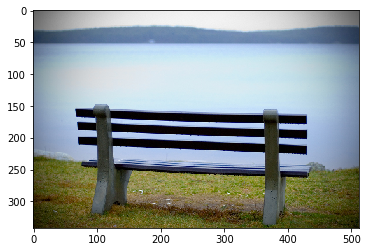

In [7]:
bench3 = imread('bench3.png')
print(bench3.dtype)
print(bench3.shape)
plt.imshow(bench3)

### Part 1: Dual Gradient Energy (Backward Energy)

First I re-implemented the backwards energy function from my class assignment and ran it:

In [8]:
def slow_dual_gradient(img):
    height = img.shape[0]
    width = img.shape[1]
    energy = np.empty((height, width))
    for i in range(height):
        for j in range(width):
            L = img[i, (j-1) % width]
            R = img[i, (j+1) % width]
            U = img[(i-1) % height, j]
            D = img[(i+1) % height, j]
            
            dx_sq = np.sum((R - L)**2)
            dy_sq = np.sum((D - U)**2)
            energy[i,j] = np.sqrt(dx_sq + dy_sq)
    return energy

Wall time: 2.24 s


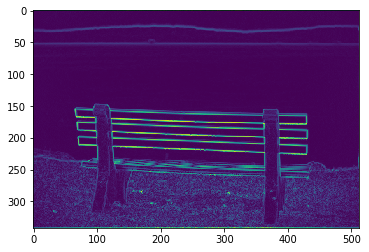

In [9]:
%time plt.imshow(slow_dual_gradient(bench3))

We test it by removing 200 seams.

Wall time: 5min 41s


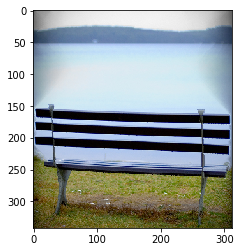

In [10]:
%time img, eimg = seam_carve(bench3, slow_dual_gradient, 200)
plt.imshow(img)

Looks just like the paper!

### Part 2: Vectorized Dual Gradient Energy

Then we take advantage of scipy to represent this same function using 2 1D convolutions for a speedup.

In [11]:
def dual_gradient(img):
    rgbx = ndi.convolve1d(img, np.array([1, 0, -1]), axis=1, mode='wrap')
    rgby = ndi.convolve1d(img, np.array([1, 0, -1]), axis=0, mode='wrap')
    
    rgbx = np.sum(rgbx**2, axis=2)
    rgby = np.sum(rgby**2, axis=2)
    
    return np.sqrt(rgbx + rgby)

Wall time: 4.84 s


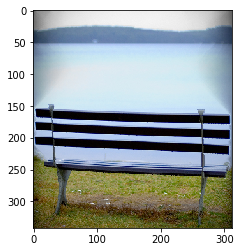

In [12]:
%time img, eimg = seam_carve(bench3, dual_gradient, 200)
plt.imshow(img)

#### Much faster! About 70x.

We quickly compare it to the built-in sobel edge detection algorithm from the seam-carving [example](http://scikit-image.org/docs/dev/auto_examples/transform/plot_seam_carving.html).

Wall time: 65.5 ms


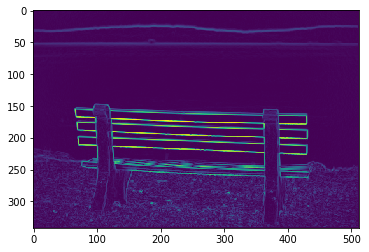

In [13]:
def backward_energy(img):
    return filters.sobel(color.rgb2gray(img))

%time plt.imshow(backward_energy(bench3))

Wall time: 2.85 s


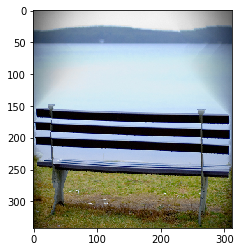

In [14]:
%time img, eimg = seam_carve(bench3, backward_energy, 200)
plt.imshow(img)

The built in filter is probably faster since it uses rgb2gray instead of the L2 color difference to calculate pixel intensities.

### Part 3: Forward Energy

Then we implemented and ran the forward energy algorithm from the paper, using rgb2gray to calculate pixel intensities:

In [15]:
def slow_forward_energy(img):
    height = img.shape[0]
    width = img.shape[1]
    
    I = color.rgb2gray(img)
    energy = np.zeros((height, width))
    m = np.zeros((height, width))
    
    for i in range(1, height):
        for j in range(width):
            up = (i-1) % height
            down = (i+1) % height
            left = (j-1) % width
            right = (j+1) % width
    
            mU = m[up,j]
            mL = m[up,left]
            mR = m[up,right]
                
            cU = np.abs(I[i,right] - I[i,left])
            cL = np.abs(I[up,j] - I[i,left]) + cU
            cR = np.abs(I[up,j] - I[i,right]) + cU
            
            cULR = np.array([cU, cL, cR])
            mULR = np.array([mU, mL, mR]) + cULR
            
            argmin = np.argmin(mULR)
            m[i,j] = mULR[argmin]
            energy[i,j] = cULR[argmin]
            
    return energy

Wall time: 1.97 s


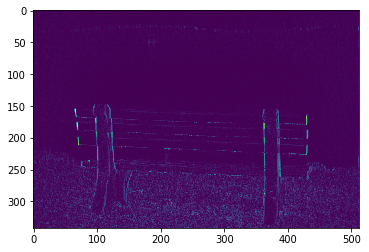

In [16]:
%time plt.imshow(slow_forward_energy(bench3))

Wall time: 5min 33s


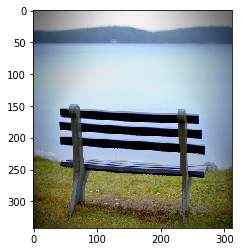

In [17]:
%time img, eimg = seam_carve(bench3, slow_forward_energy, 200)
plt.imshow(img)

Looks just like the paper!

### Part 4: Vectorized Forward Energy

Using [np.roll](https://docs.scipy.org/doc/numpy/reference/generated/numpy.roll.html)
we can vectorize the function, eliminating the inner loop in the dynamic programming step for a speedup.

From my Google and GitHub searching, I found no implementations online that vectorize the dynamic programming step.

I haven't looked closely, but the dynamic programming step in the [\_preprocess\_image](https://github.com/scikit-image/scikit-image/blob/master/skimage/transform/_seam_carving.pyx) function in scikit-image uses a double for loop and might be able to be optimized for further speedup.

In [18]:
def forward_energy(img, flag=False):
    height = img.shape[0]
    width = img.shape[1]
    I = color.rgb2gray(img)
    
    energy = np.zeros((height, width))
    m = np.zeros((height, width))
    
    U = np.roll(I, 1, axis=0)
    L = np.roll(I, 1, axis=1)
    R = np.roll(I, -1, axis=1)
    
    cU = np.abs(R - L)
    cL = np.abs(U - L) + cU
    cR = np.abs(U - R) + cU
    
    for i in range(1, height):
        m_two_rows = m[i-1:i+1]  # crucial optimization

        mU = np.roll(m_two_rows, 1, axis=0)[1]
        mL = np.roll(m_two_rows, 1, axis=(0,1))[1]
        mR = np.roll(m_two_rows, (1, -1), axis=(0,1))[1]

        mU += cU[i]
        mL += cL[i]
        mR += cR[i]

        mULR = np.array([mU, mL, mR])
 
        argmins = np.argmin(mULR, axis=0)

        m[i] = np.choose(argmins, mULR)
    
        cULR = np.array([cU[i], cL[i], cR[i]])
        energy[i] = np.choose(argmins, cULR)
        
    return energy

Wall time: 14.1 s


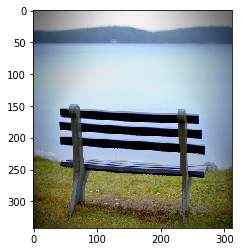

In [19]:
%time img, eimg = seam_carve(bench3, forward_energy, 200)
plt.imshow(img)

#### I got a 30x speedup.

A further optimization would be changing the skimage.transform.seam_carve function to accept the accumulated cost matrix (the m matrix in the function) since forward energy calculates it directly. Right now, I calculate the energy matrix backward from the m matrix. 

### Part 5: Examples

Now I will compare the outputs between the backward and forward energy algorithms.

I write a helper plotting function, but I have no idea if this is the best way to do it...

In [20]:
def compare_energy(img, n, filename):
    """
    A helper function to compare backward and forward energy.
    
    :param img: image to carve
    :param int n: number of seams to carve
    """
    w = img.shape[1]
    gs = gridspec.GridSpec(3, 2,
                       width_ratios=[w, w - n],
                       height_ratios=[1, 1, 1]
                       )

    plt.figure(figsize=(14, 14))
    
    plt.subplot(gs[0])
    plt.imshow(img)
    plt.title('Original Image')
    
    plt.subplot(gs[2])
    plt.imshow(backward_energy(img))
    plt.title('Backward Energy')

    plt.subplot(gs[3])
    backward_img, _ = seam_carve(img, backward_energy, n)
    plt.imshow(backward_img)
    plt.title('Backward Carving')
    
    plt.subplot(gs[4])
    plt.imshow(forward_energy(img))
    plt.title('Forward Energy')
    
    plt.subplot(gs[5])
    forward_img, _ = seam_carve(img, forward_energy, n)
    plt.imshow(forward_img)
    plt.title('Forward Carving')
    
    plt.show()
    
    plt.imsave('samples/' + filename + '_backward.jpg', backward_img)
    plt.imsave('samples/' + filename + '_forward.jpg', forward_img)

In [21]:
# Images from paper and number of seams to remove
paper = [
    ('bench3.png', 200),
    ('pliers.jpg', 100),
    ('bench2.png', 400),
    ('arch.png', 300),
    ('car1.png', 150),
    ('ratatouille.png', 250),
    ('rain.png', 150)
]

paper = [(imread('samples/' + filename), n, filename.split('.')[0]) for filename, n in paper]
 
# Images we chose
ours = [
    ('blair.jpg', 200),
    ('teapot.jpg', 150),
    ('p_arch.jpg', 350),
    ('house.jpg', 200)
]

ours = [(imread('samples/' + filename), n, filename.split('.')[0]) for filename, n in ours]

First, we carve a few images from the paper itself.

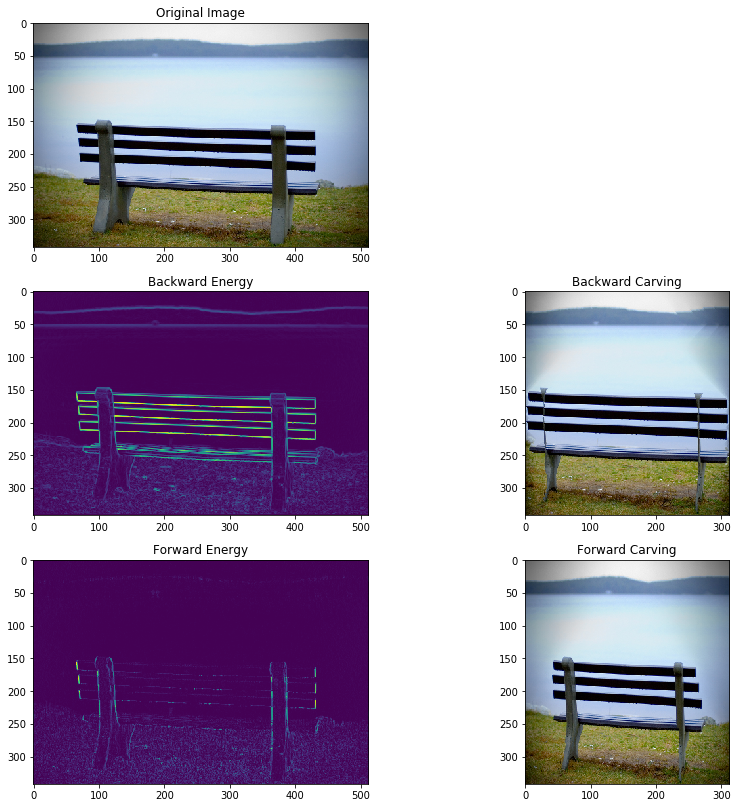

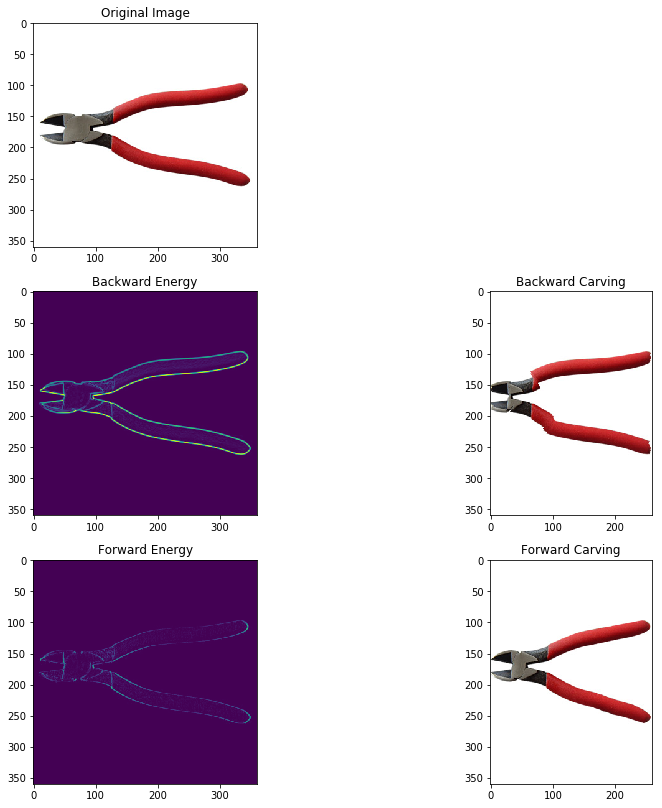

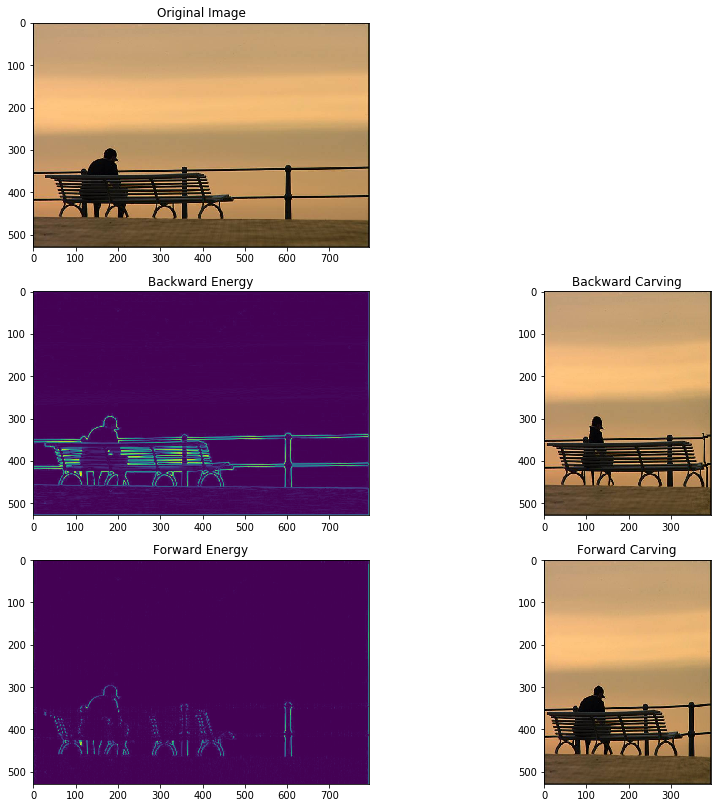

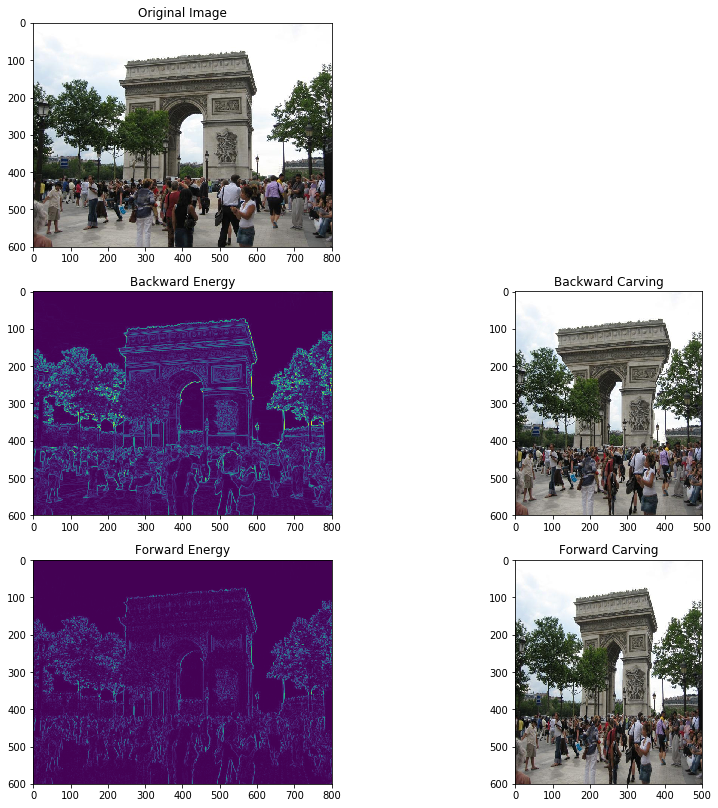

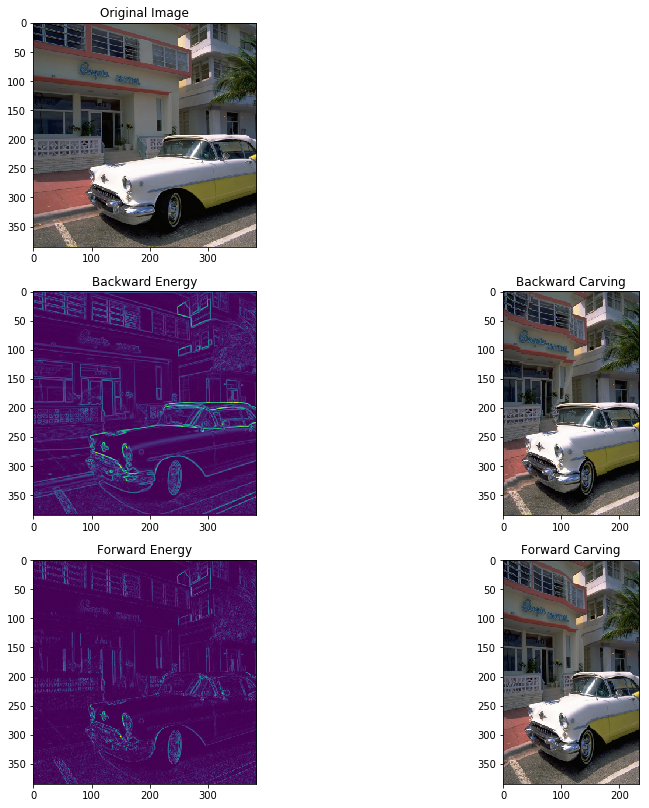

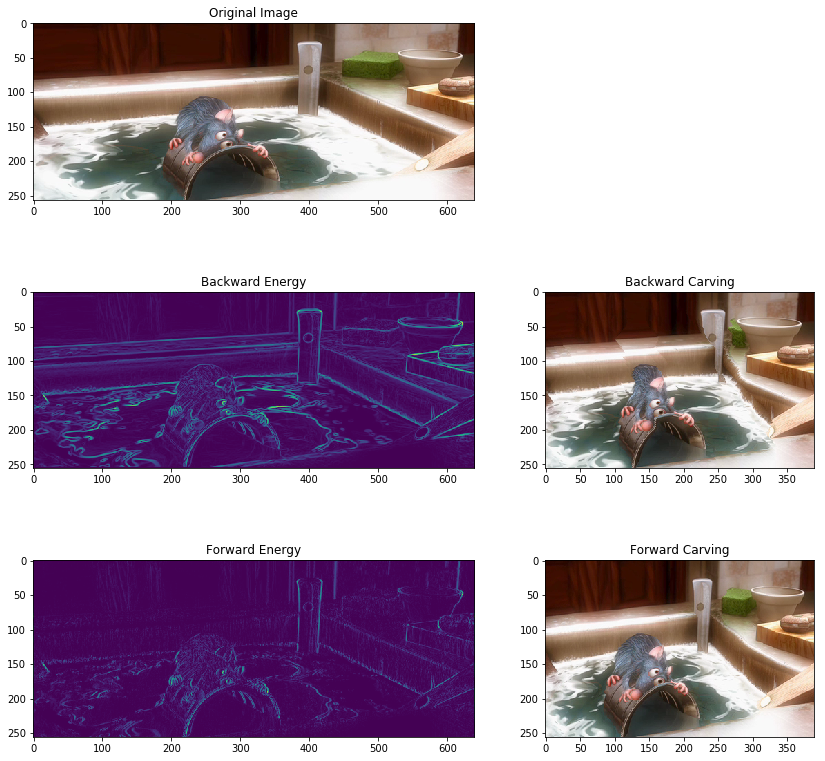

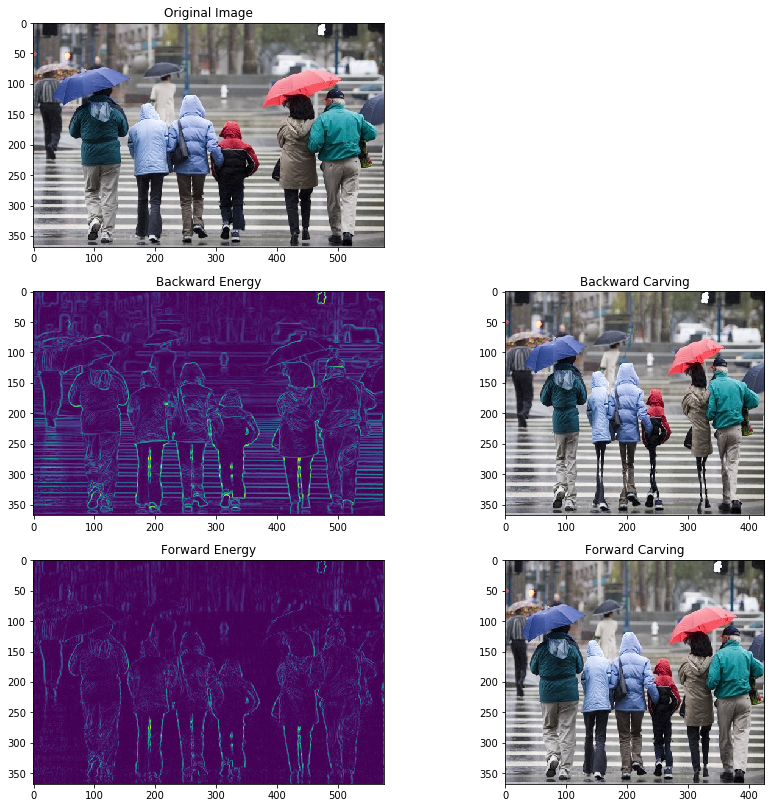

In [22]:
for img, n, name in paper:
    compare_energy(img, n, name)

Then we carve a few of our own images:

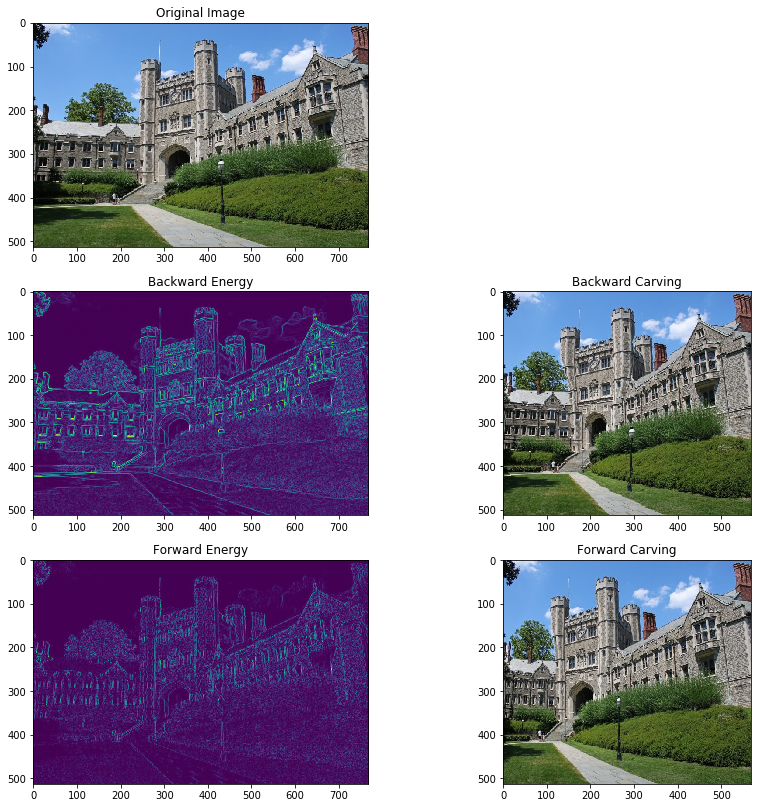

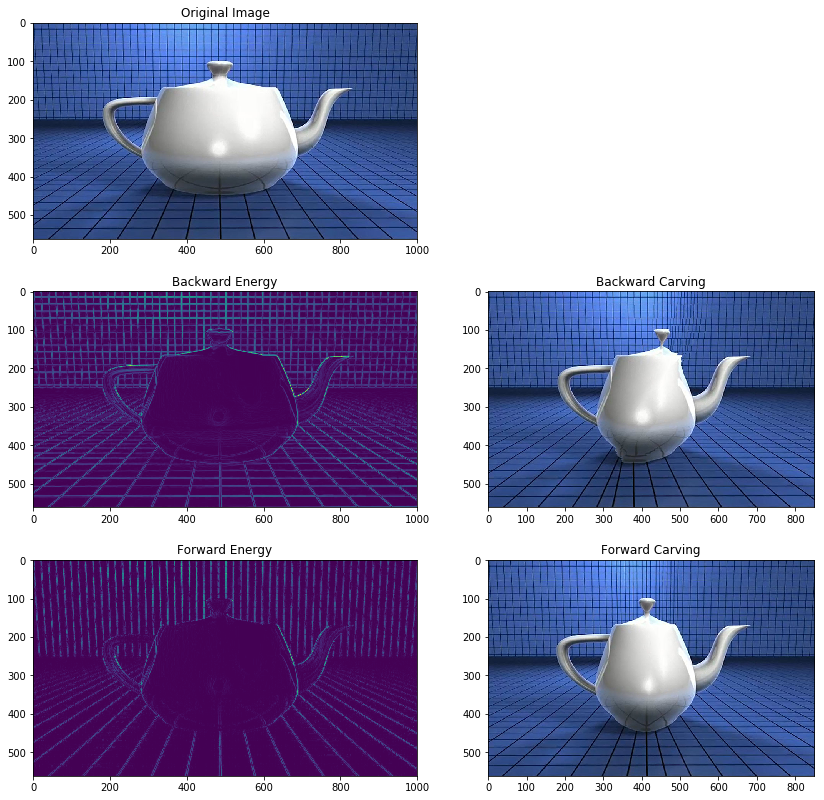

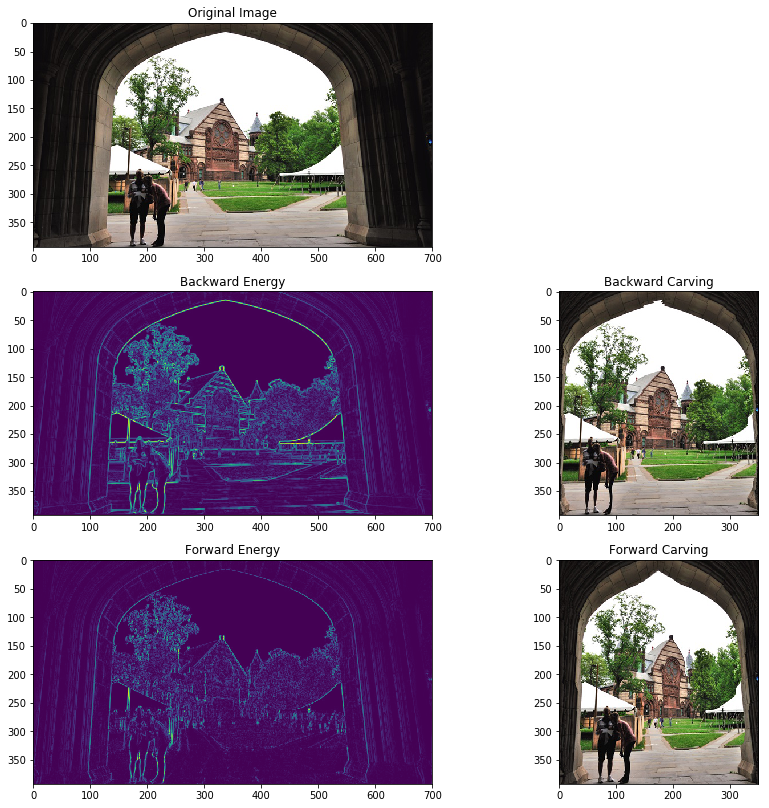

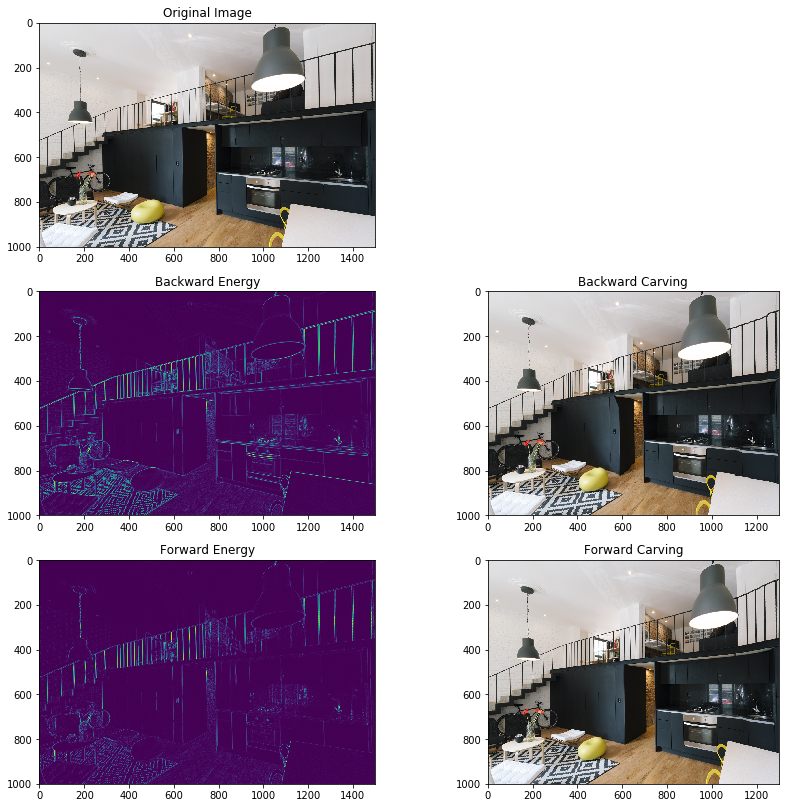

In [23]:
for img, n, name in ours:
    compare_energy(img, n, name)

### Part 6: Next steps

I need to implement it horizontally too. And then I'll submit it to scikit-image as the default energy function:

https://github.com/scikit-image/scikit-image/issues/3082

https://github.com/scikit-image/scikit-image/issues/2808

### Acknowledgements

Yun Teng '19 and Ji-Sung Kim '19 for numpy help